In [23]:
import numpy as np
import sys
sys.path.append('../')

# Propositional Classifiers:

In this notebook I try to design classifiers that act on the set of all blocks and output a tiebreaker binary label having access only to the features given by Henry in the focal students dataset. Those features are:

1. Total number of students per block (used for normalization purposes)
2. Number of FRL students per block
3. Number of AALPI students per block
4. Number of FRL and AALPI students per block (i.e. intersection of those)
5. Number of FRL or AALPI students per block (i.e. union)

The column names available are:

1. n
2. nFRL and pctFRL
3. nAALPI and pctAALPI
4. nBoth and pctBoth
5. nFocal and pctFocal

The classifiers will evaluate a logical proposition with those features. For example, an "AND" classifier can be of the form:

$$ \text{AALPI} \geq 0.5 \quad \text{and} \quad \text{FRL} \geq 0.7 $$

This classifier will give an equity tiebreaker to a block if and only if that block has over 50% of its students in the AALPI racial group and over 70% of its students receiving FRL.

Currently we do not have a systematic way to think of these types of propositions. But we can evaluate their performance based on false positive and false negative rates. In the case of two parameters (i.e. two numeric comparisons), it is possible to visualize the precision-recall curve.

## 1. Class Syntax

We load the propositional classifier classes from the modelling library:

In [24]:
from src.d04_modeling import propositional_classifier as pc

RMK: The first classifier will take some extra seconds to be initialized in order for the data to load

In [25]:
load_data = pc.andClassifier([])

In its most general form, the propositional classifier class takes as an input a list of features that we will be using for evaluation, a list of logical operators ("and" or "or"), and a list of comparisors ($\geq$, $\leq$, =). By default, this comparisor lists is a sequence of $\geq$ since that is the most likely case. The lists must be in the order of the statement we want to construct, and notice that there will always be one less operator than features. For example:

In [26]:
pc1 = pc.PropositionalClassifier(["pctAALPI", "pctFRL", "nBoth"], ["and", "or"])
pc1.statement

'pctAALPI >=  {0:.2f} and pctFRL >=  {1:.2f} or nBoth >=  {2:.2f}'

Note that the parameters are not required upon initialization. Rather, the statement is constructed so we can input parameters when doing the predictions. This way we can vary parameters and build precision-recall cruves.

Simple and/or classifiers have their own child class, in which we only need to pass the features (and comparisors if not default):

In [27]:
pc2 = pc.andClassifier(["pctAALPI", "pctFRL"])
pc2.statement

'pctAALPI >=  {0:.2f} and pctFRL >=  {1:.2f}'

In [28]:
pc3 = pc.orClassifier(["pctAALPI", "pctFRL"])
pc3.statement

'pctAALPI >=  {0:.2f} or pctFRL >=  {1:.2f}'

Some logical statements need parentheses. Some do not, but we would rather read them with parentheses as that is easier (for example, the first example pc1 is hard to interpret without parenthesis---computer evaluates it in order). Simply pass a tuple of features as an element. Note that operands must still be of the correct length!

In [29]:
pc4 = pc.PropositionalClassifier(["pctAALPI", ("pctFRL", "pctBoth"), "nBoth"], ["or", "and", "or"])
pc4.statement

'pctAALPI >=  {0:.2f} or  (pctFRL >=  {1:.2f} and pctBoth >=  {2:.2f} ) or nBoth >=  {3:.2f}'

Once we have initialized our statement we can use the get_solution_set method with the appropriate parameters to do a round of prediction.

In [30]:
params1 = [0.5, 0.8, 6] #parameters must match the features passed, in the order. Note the scale.
pred1 = pc1.get_solution_set(params1)
pred1

Int64Index([60750604001011, 60750179021001, 60750179021027, 60750179021035,
            60750179021026, 60750179021034, 60750179021010, 60750179021017,
            60750615001008, 60750615002000,
            ...
            60750314003006, 60750262005014, 60750313021007, 60750313023001,
            60750313021005, 60750262005017, 60750262005012, 60750313023029,
            60750354001000, 60750354001005],
           dtype='int64', name='geoid', length=704)

This index object tells us which blocks receive the tiebreaker. We can visualize the result in the San Francisco map:

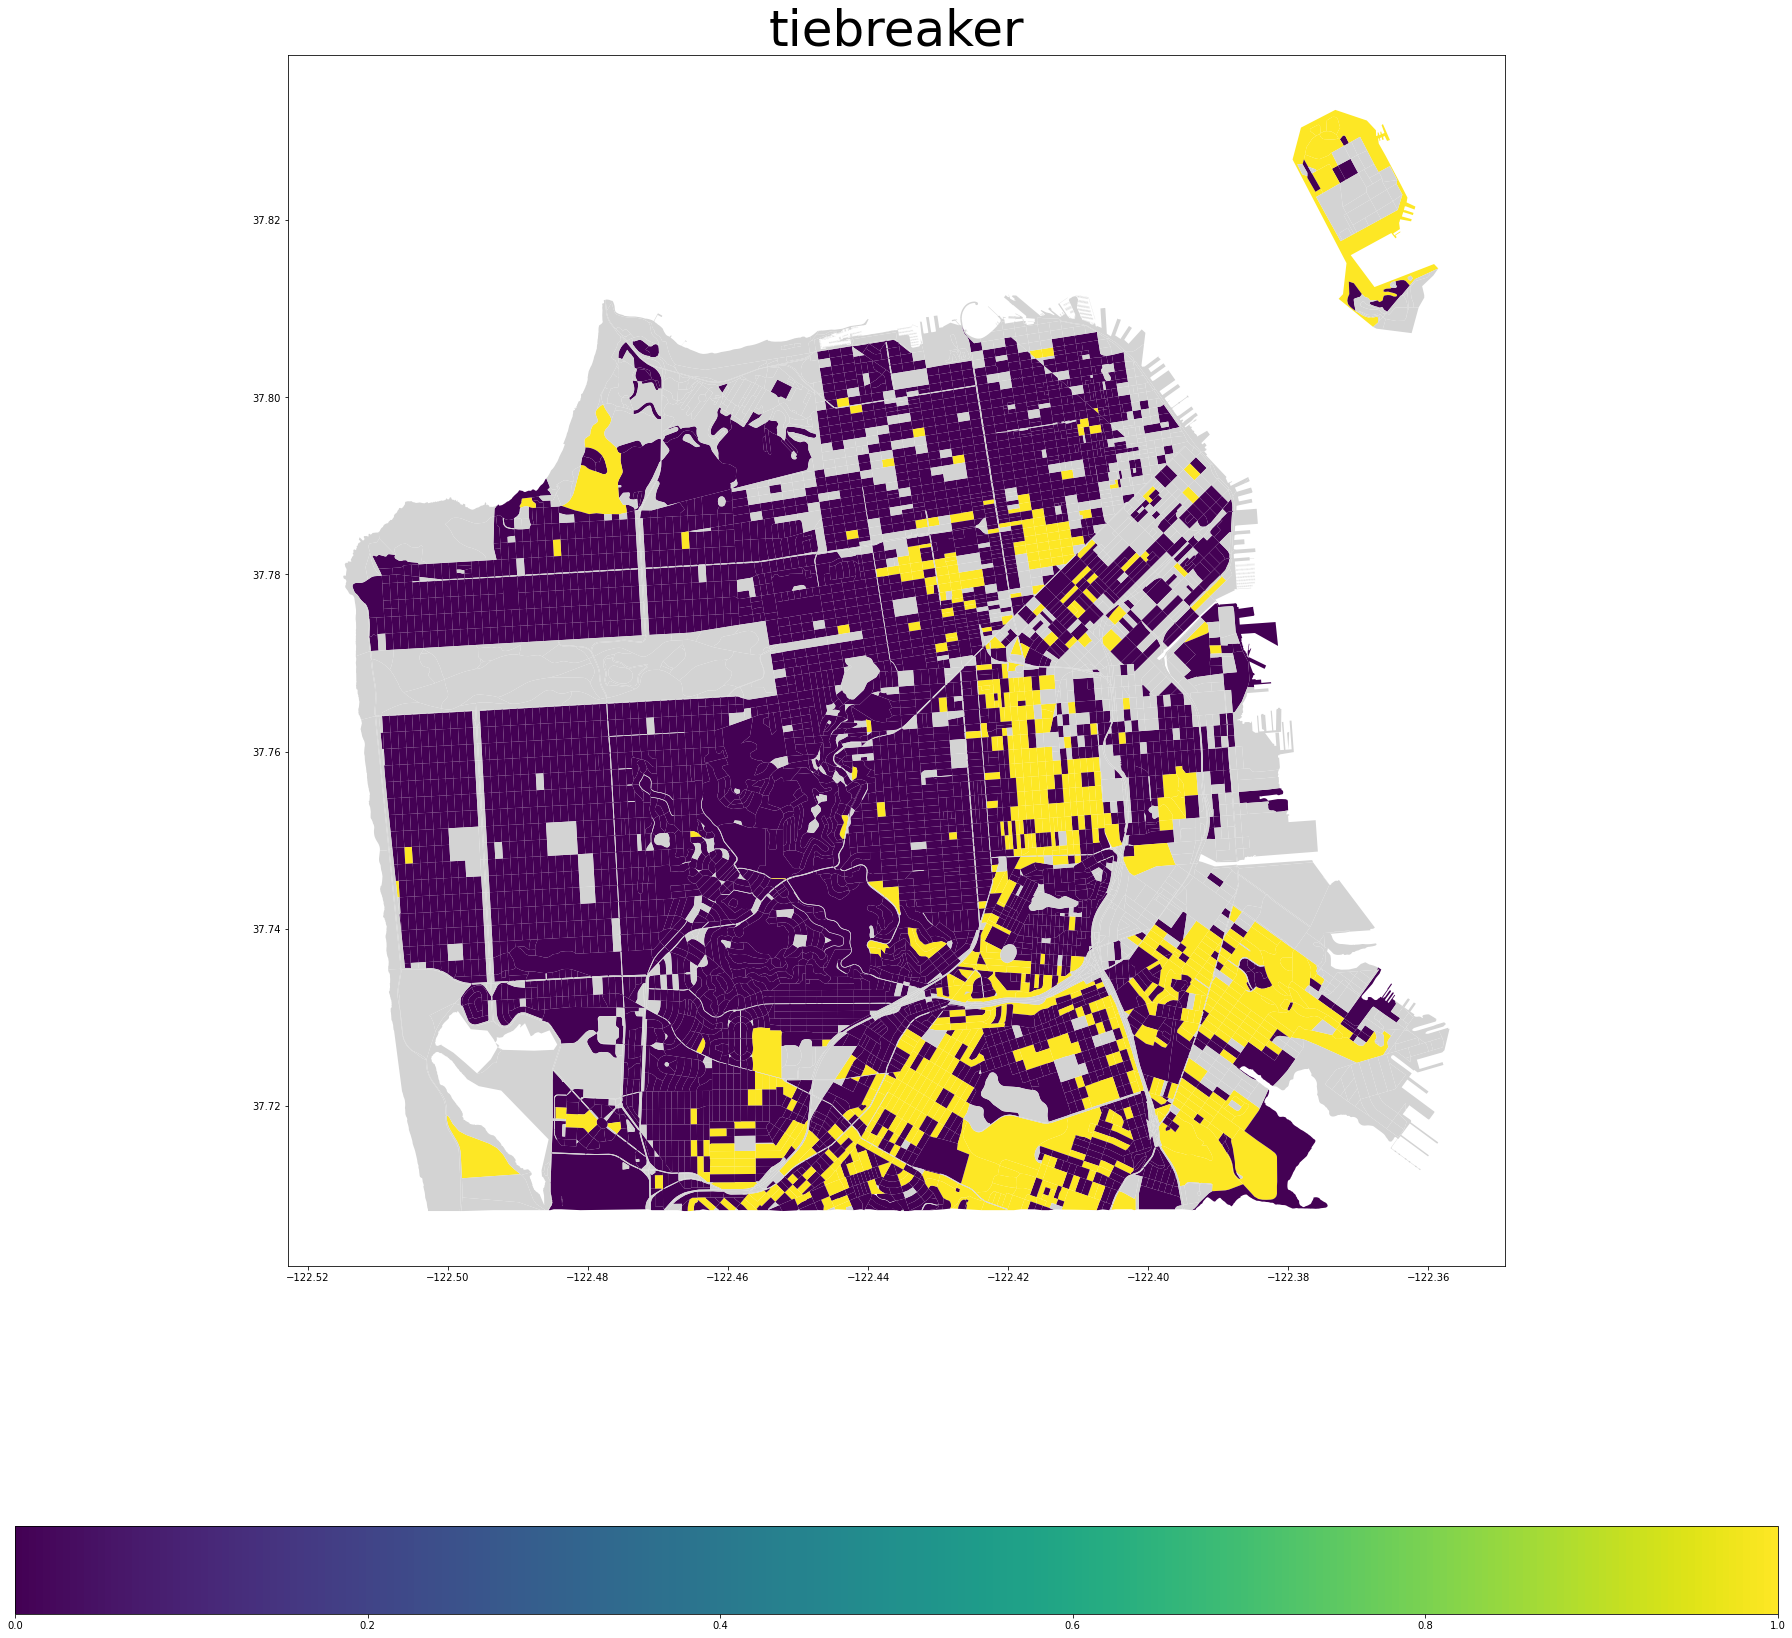

In [31]:
ax = pc1.plot_map(params1)

The confusion matrix of this classifier can be retrieved using the get_confusion_matrix method:

In [32]:
cm1 = pc1.get_confusion_matrix(params1)
cm1

Real\Pred,1,0
nFocal,19207.333333,16462.166667
nOther,2950.083333,16975.250000


Using that we can retrive any rate for evaluating purposes. We can get the FPR and FNR for example:

In [33]:
print("False positive rate is {0:.2f} %".format(100*pc1.fpr(params1)))
print("False negative rate is {0:.2f} %".format(100*pc1.fnr(params1)))

False positive rate is 14.81 %
False negative rate is 46.15 %


To interpret the above map: we wanted the FRL percentage to be very high (above 80%) and the AALPI percentage to be at least half; OR if there were at least 10 students in a block in the intersection count, the block would be given a tiebreaker regardless of its relative composition. We can see in the map that due to the AALPI criterion having to be satisfied most blocks that received a tiebreaker are in the SouthEast (where racial minorities are more concentrated). This criterion is very restrictive: the false negative rate is super high, meaning that we "missed" a lot of focal students. However, very few non-focal students received an advantage (less that 15%).

## 2. Exploring the parameter space

Ideally we would like to explore several points for the trade-off between FP and FN.

In one-dimensional parameter spaces (i.e. only one feature is pased to the classifier, so that we have only one parameter) this can be done via analysis of the ROC curve (similar to precision-recall):

In [34]:
pc5 = pc.PropositionalClassifier(["pctBoth"], [])

In [35]:
pc5.statement

'pctBoth >=  {0:.2f}'

In [36]:
params_arr = [x for x in np.linspace(0, 1, num=100)]
ROC5_df = pc5.get_roc(params_arr)
ROC5_df

,tpr,fpr
0,1.000000,1.000000
1,0.872393,0.580011
2,0.855082,0.546059
3,0.833768,0.509209
4,0.818853,0.473915
...,...,...
95,0.001635,0.000000
96,0.001635,0.000000
97,0.001635,0.000000
98,0.001635,0.000000


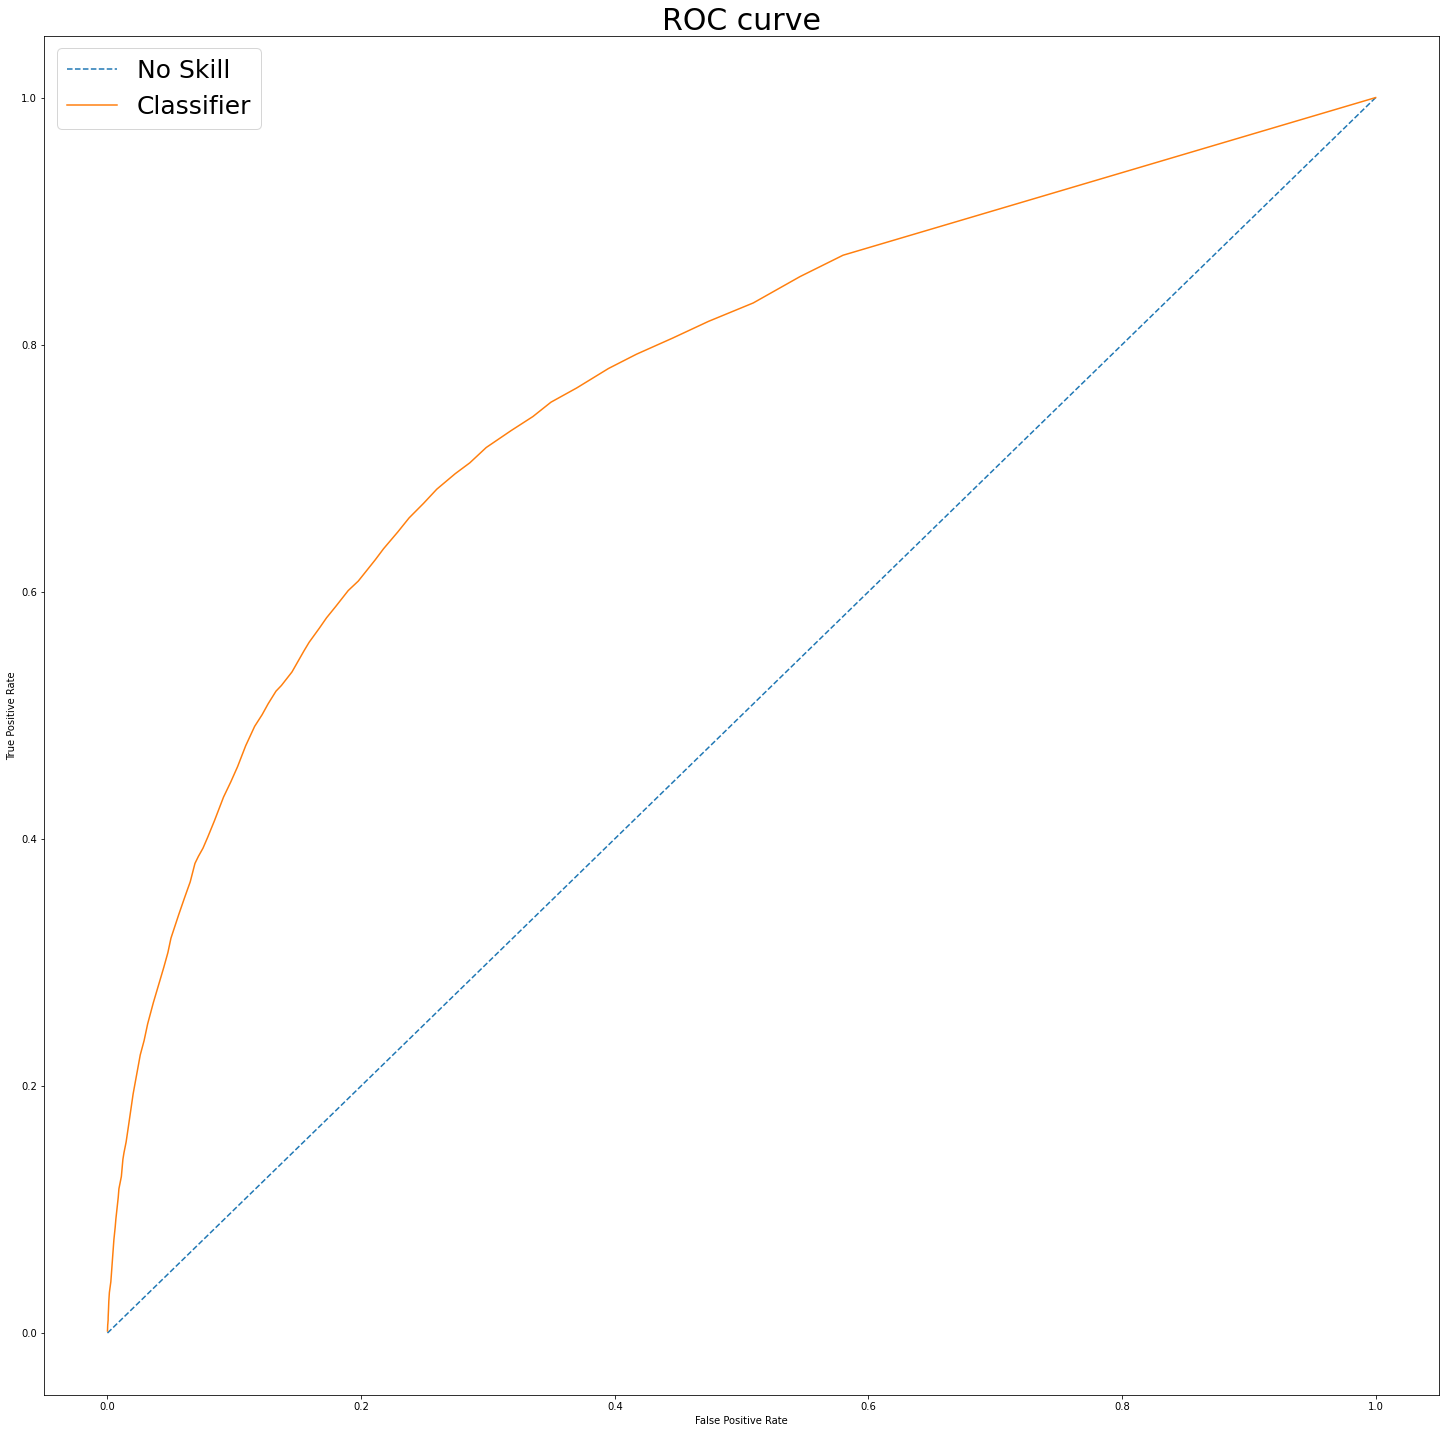

<AxesSubplot:title={'center':'ROC curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [37]:
pc5.plot_roc(params_arr)

In two-dimensional parameter spaces (i.e. only two features are pased to the classifier, so that we have only two parameters) this can be done via analysis of two matrices of false positives and false negatives. This would be equivalent to a ROC surface.

In [38]:
pc2.statement

'pctAALPI >=  {0:.2f} and pctFRL >=  {1:.2f}'

array([<AxesSubplot:title={'center':'False Positive Rate'}>,
       <AxesSubplot:title={'center':'False Negative Rate'}>], dtype=object)

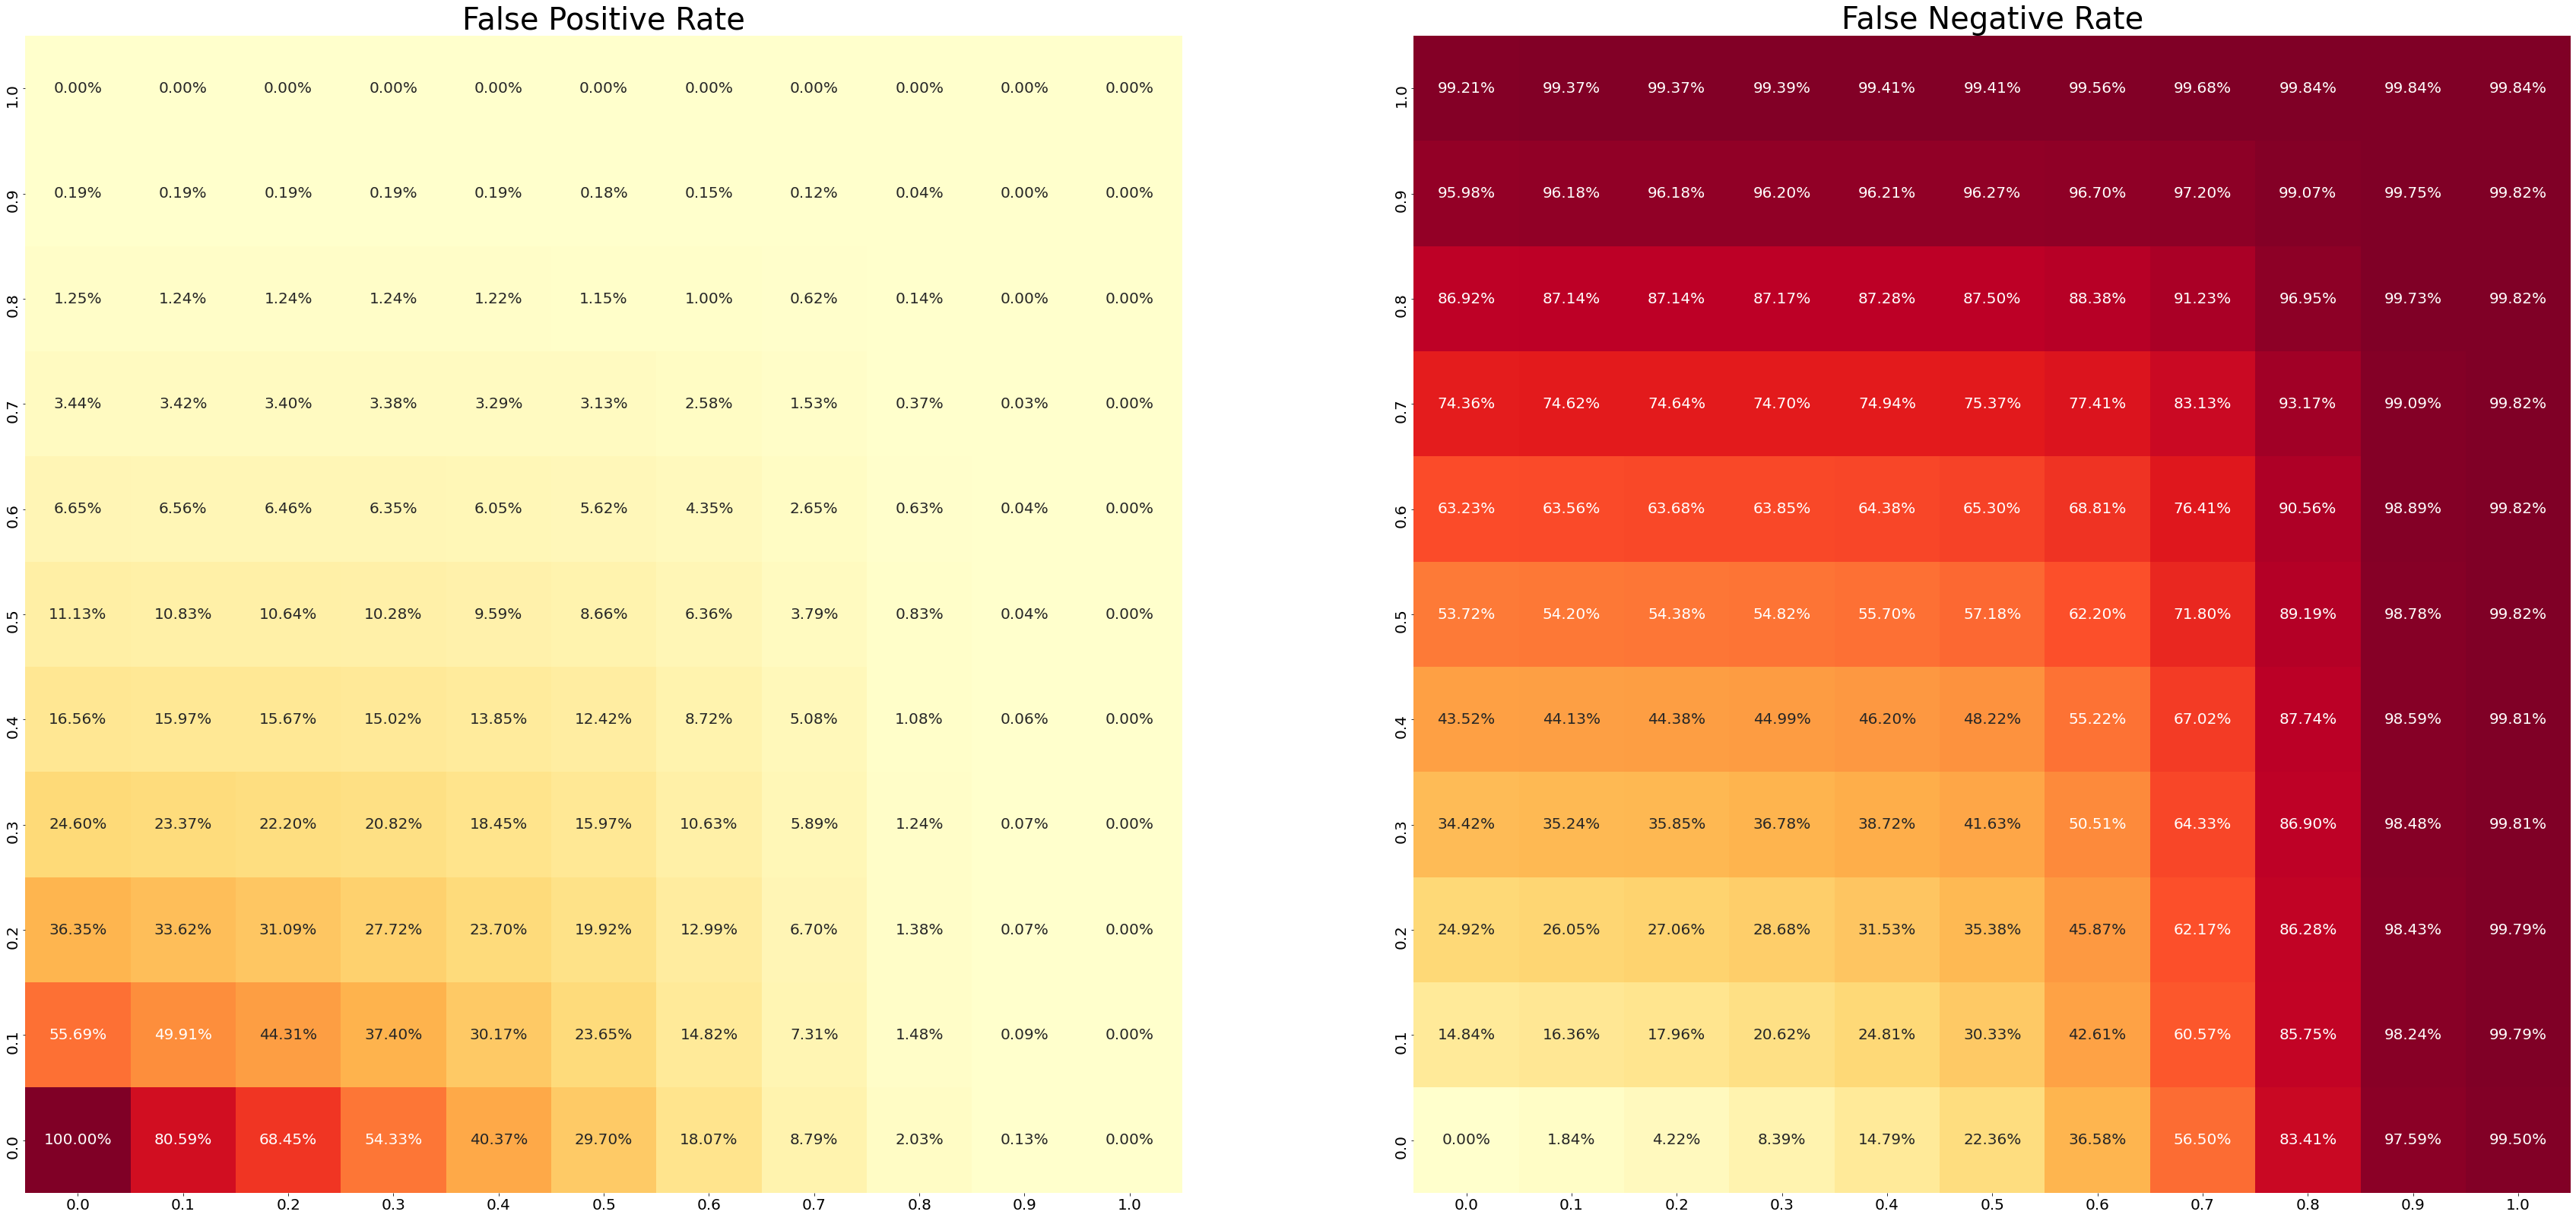

In [39]:
params_arr2 = [x/10 for x in range(11)]
pc2.plot_heatmap(params_arr2)

An alternative is to fix all but one parameters of the propositions so that we can build a ROC curve. Using:

$$ \left(\text{AALPI } \geq 50\%  \quad \text{and} \quad \text{FRL } \geq 60\%\right)\quad\text{or}\quad \text{BOTH } (\%)\geq \gamma$$

In [40]:
pc6 = pc.PropositionalClassifier([("pctAALPI", "pctFRL"), "pctBoth"], ["and", "or"])
pc6.statement

'(pctAALPI >=  {0:.2f} and pctFRL >=  {1:.2f} ) or pctBoth >=  {2:.2f}'

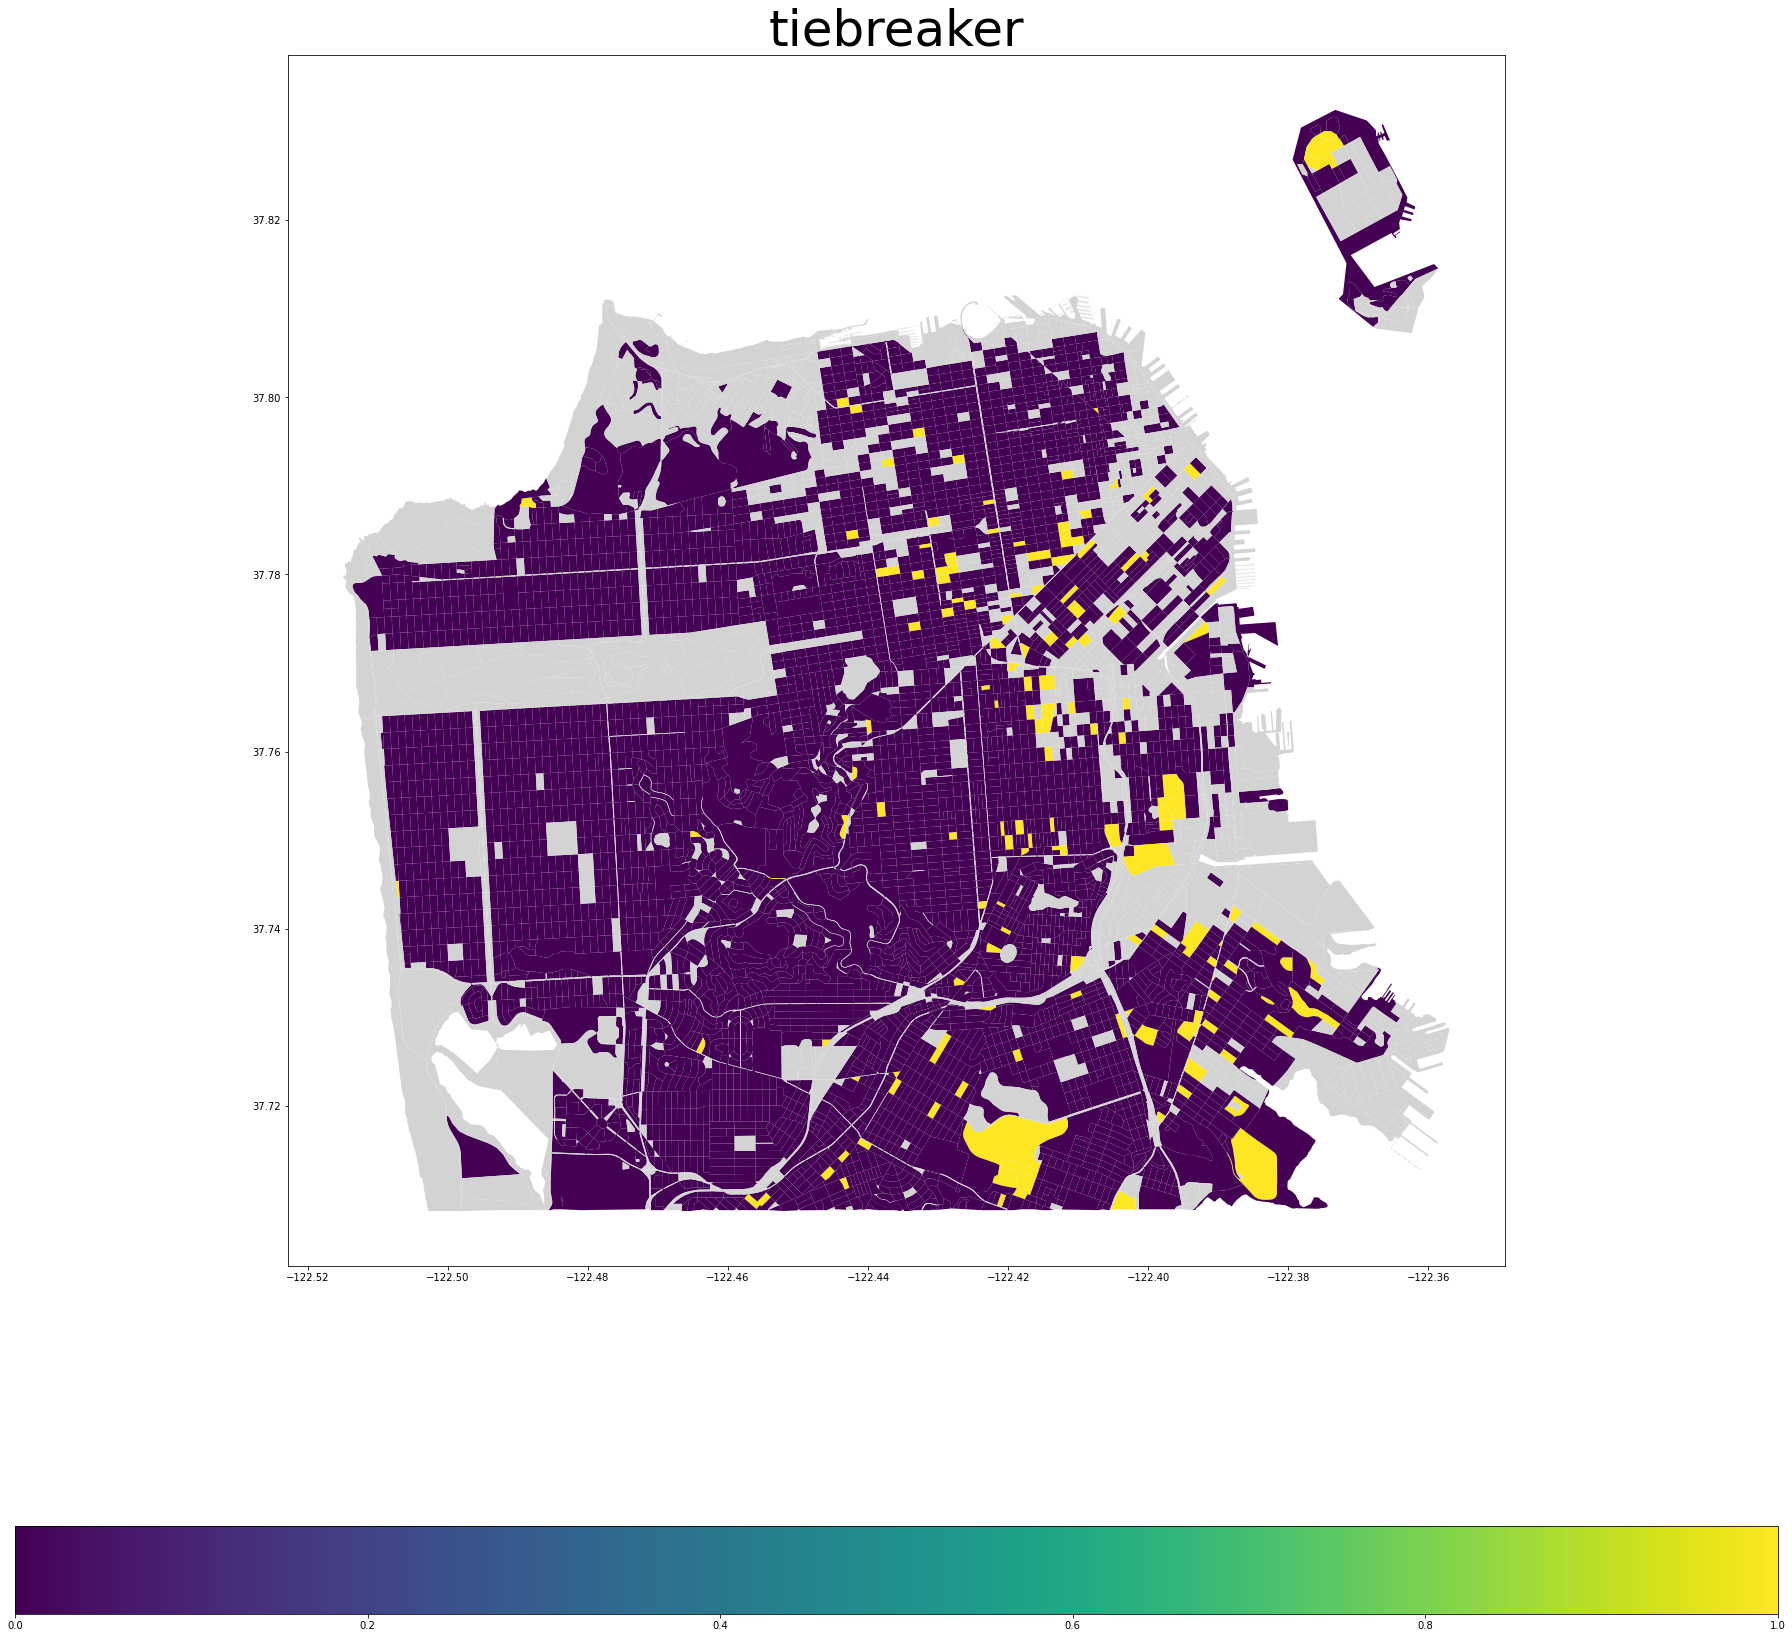

<AxesSubplot:title={'center':'tiebreaker'}>

In [43]:
params_6 = [0.5, 0.8, 6]
pc6.plot_map(params_6)

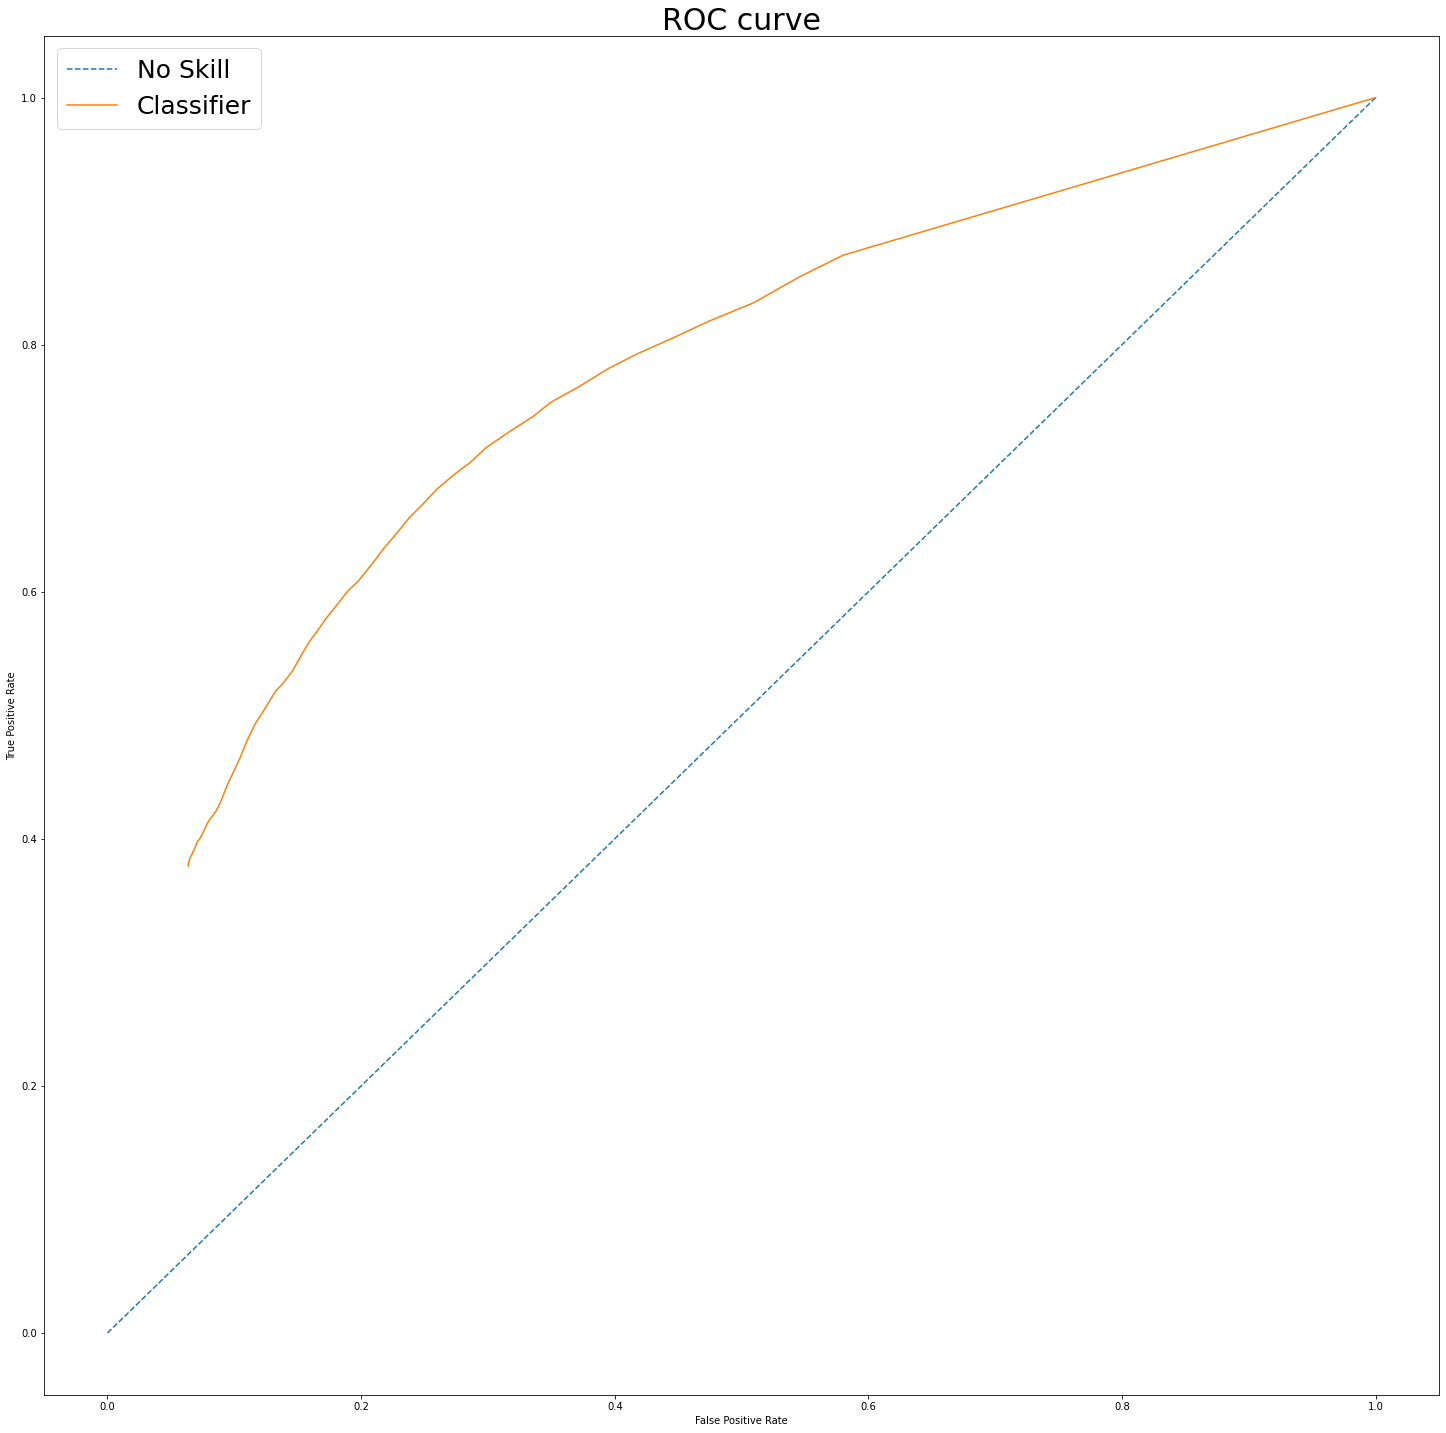

<AxesSubplot:title={'center':'ROC curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [41]:
params_arr6 = [[0.5, 0.6, x] for x in np.linspace(0, 1, num=100)]
pc6.plot_roc(params_arr6)

Note that because we are looking at a subset of the parameter space, we cannot acheive all possible values of FPR/TPR